# Uniform seeding of the Caribbean 

Mass of particles is based on Jambeck et al. 2015

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import path, colors
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import urllib.request
import skimage.io as io
import copy
import os
from os.path import join
from datetime import datetime
import scipy as sc
from scipy import stats
import xarray as xr
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import generic_filter
import shapely
import cmocean
import numba as nb

In [2]:
import sys
sys.path.append('/nexsan/people/pmiron/projects_mars/HYCOM-utilities/python/')
import hycom.io as hio

In [3]:
from caribbean_map import *

In [4]:
# parameters
mpw_to_ocean_ratio = 0.25   # Jambeck and Lebreton
light_particle_ratio = 0.6  # Lebreton, meaning that 40% sink on release

In [5]:
caribbean_countries = [ # countries
    'Antigua and Barbuda', 'Bahamas', 'Barbados',
    'Cuba', 'Dominica', 'Dominican Republic',
    'Grenada', 'Haiti', 'Jamaica', 'Saint Kitts and Nevis',
    'Saint Lucia', 'Saint Vincent and the Grenadines',
    'Trinidad and Tobago',
    # dependant teritory
    'Anguilla', 'Aruba',
    'Bonaire, Sint Eustatius and Saba',
    'British Virgin Islands', 'Cayman Islands',
    'Curaçao', 'Guadeloupe', 'Martinique',
    'Montserrat', 'Puerto Rico', 'Saint-Barthélemy',
    'Saint-Martin', 'Sint Maarten',
    'Turks and Caicos Islands', 'Virgin Islands, U.S.',
    # other countries
    'Mexico', 'United States', 'Venezuela', 'Belize', 'Colombia',
    'Costa Rica', 'Guatemala', 'Guyana', 'Honduras', 'Nicaragua', 'Panama',
    'Suriname']

# Uniform distribution using Jambeck et al. 2015 ([2010](https://ourworldindata.org/grapher/mismanaged-plastic-waste), [2025](https://ourworldindata.org/grapher/mismanaged-plastic-waste-in-2025))

1. they quantified plastic waste generated by coastal populations (those within *50 kilometres of a coastline*) — this represents plastic waste with the potential to be transported to the coast. Plastic waste generated further inland is unlikely to travel this distance.

2. they corrected this figure for the quantity of plastic waste that is mismanaged. Mismanaged waste is the sum of inadequately managed waste (that which is not formally managed such as disposal in dumps or open, uncontrolled landfills which could leak to the surrounding environment) and littered waste. Mismanaged waste within coastal populations has strong potential to eventually enter the ocean either through transport by wind or tides, or through waterways such as rivers or wastewater.

From the tons of MPW, **25% is expected to end up in the Ocean**.

In [6]:
raw = pd.read_csv('../data/raw/jambeck-2015/mismanaged-plastic-waste.csv', delimiter=',')
raw = raw.rename(columns={'Entity': 'Country'})
raw.drop(columns=['Code'], inplace=True) # drop columns we won't need

In [7]:
raw.head()

,Country,Year,Total mismanaged plastic waste in 2010
0,Albania,2010,29705
1,Algeria,2010,520555
2,Angola,2010,62528
3,Anguilla,2010,52
4,Antigua and Barbuda,2010,1253


In [8]:
mpw = np.zeros(len(caribbean_countries))

for i, c in enumerate(caribbean_countries):
    j = np.where(raw.Country == c)[0]
    if len(j):
        mpw[i] = raw.iloc[j]['Total mismanaged plastic waste in 2010']
    else:
        print(f'No data {c} (index={i})')

No data Bonaire, Sint Eustatius and Saba (index=15)
No data Curaçao (index=18)
No data Saint-Barthélemy (index=23)
No data Saint-Martin (index=24)
No data Sint Maarten (index=25)
No data Virgin Islands, U.S. (index=27)


## Data for missing countries
- some countries are not found because they are recorded with a different name
- in the case of missing data, we estimate the mismanaged plastic wasted from nearby country and scale by the population ratio 

In [9]:
# Netherlands Antilles = Bonaire, Sint Eustatius and Saba
j = np.where(raw.Country.str.contains('Netherlands Antilles'))[0]
mpw[15] = raw.iloc[j]['Total mismanaged plastic waste in 2010']

# Curacao
j = np.where(raw.Country.str.contains('Curacao'))[0]
mpw[18] = raw.iloc[j]['Total mismanaged plastic waste in 2010']

# Saint-Barthélemy Population 9,961
# scale with Anguilla Population 14,731 (2018)
j = np.where(raw.Country.str.contains('Anguilla'))[0]
mpw[23] = raw.iloc[j]['Total mismanaged plastic waste in 2010'] * 9961/14731

# Saint-Martin Population 73,666 (2019)
j = np.where(raw.Country.str.contains('Sint Maarten'))[0]
mpw[24] = raw.iloc[j]['Total mismanaged plastic waste in 2010'] * 73666/40812

# Sint Maarten (Dutch part) Population 40,812 (2020)
j = np.where(raw.Country.str.contains('Sint Maarten'))[0]
mpw[25] = raw.iloc[j]['Total mismanaged plastic waste in 2010']

# Virgin Islands Population 106,290 (2020)
# British Virgin Island Population 30,237 (2020)
# Scale by population with the British Virgin Island
mpw[27] = raw.iloc[18]['Total mismanaged plastic waste in 2010'] * 106290/30237

# Dataframe with MPW estimates from Jambeck et al

The variable `nb_ocean_coastlines` contains the number of gridcell in the ocean-coastlines, which is 2 bins away from the land grid in HYCOM. This is used to determine how much MPW is uniformly injected in each cell for a given country. This step is necessary because we are using a subregion, so country like Mexico and USA have coastlines outside of the Caribbean region.

In [10]:
with xr.open_dataset('../data/process/country_GLBv0.08.nc') as ds:
    df = pd.DataFrame(data=np.column_stack([ds.country_list, mpw]), columns=['country', 'mpw [ton/year]'])
    nb_ocean_coastlines = [np.sum((ds.ocean_coastlines_country == c_id).values) for c_id in range(0, len(ds.country_list))]
    df['uniform mpw [ton/year/gridcell]'] =  df['mpw [ton/year]'] / nb_ocean_coastlines  

In [11]:
df.head()

,country,mpw [ton/year],uniform mpw [ton/year/gridcell]
0,Antigua and Barbuda,1253.0,27.23913
1,Bahamas,1333.0,2.406137
2,Barbados,3483.0,145.125
3,Cuba,90630.0,171.973435
4,Dominica,783.0,32.625


In [12]:
xc = np.array([-51.6, -76.8, -78, -79.3, -81, -82.7, -87.3, -98.5, -98.5, -66.7, -51.6, -51.6])
yc = np.array([3.5, 7, 8.6, 9.2, 8.2, 8.8, 14.8, 19.0, 31.0, 31.0, 31.0, 3.9])
p = path.Path(np.vstack((xc, yc)).T)
    
def caribbean_filter(x, y):
    '''
    Return mask to filter particles on the Pacific Ocean coast    
    '''
    return p.contains_points(np.column_stack((x, y)))

def gridcell_country(c_id):
    '''
    Return (qlon, qlat) of gridcell of a given country
    '''
    with xr.open_dataset('../data/process/country_GLBv0.08.nc') as ds:
        plon = ds.plon
        plat = ds.plat
        
        ocean_coast = (ds.ocean_coastlines_country == c_id)
        j, i = np.where(ocean_coast)
        return i, j, plon[i], plat[j]    

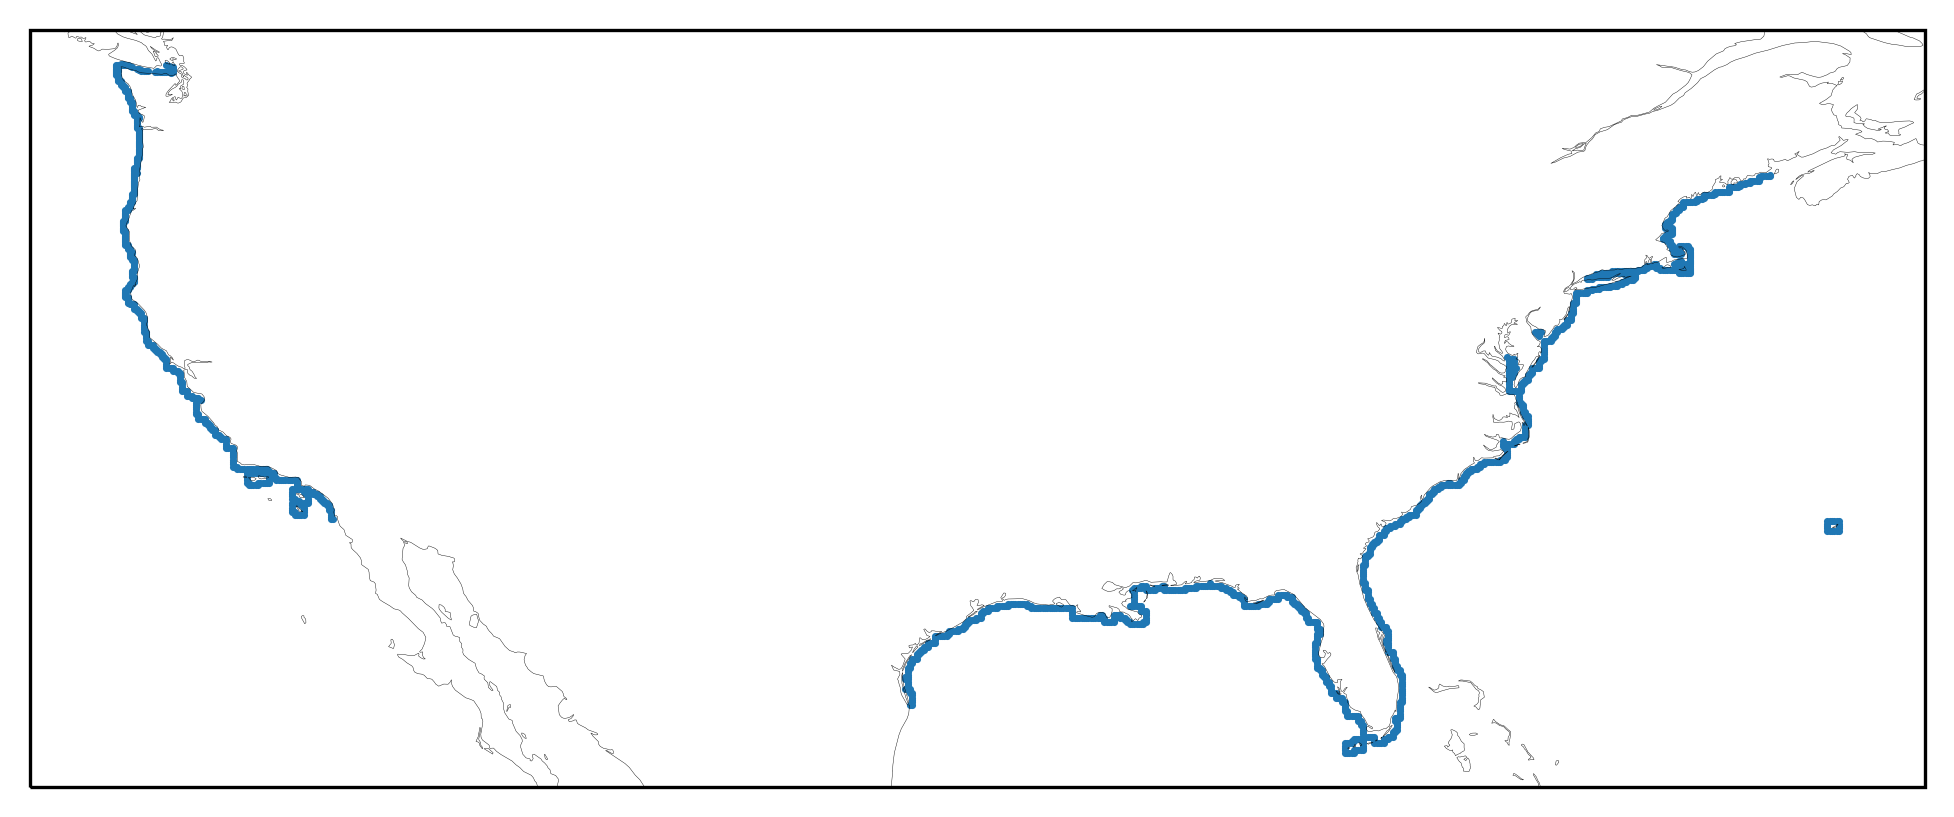

In [13]:
# uniform mpw in the region
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1,aspect='equal', projection=ccrs.PlateCarree())

c_id = 29  # mexico 28, usa 29
i,j,x,y = gridcell_country(c_id)
#k = caribbean_filter(x,y)
#i,j,x,y = i[k], j[k], x[k], y[k]

ax.scatter(x, y, s=0.5, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=0.1, zorder=1)

# Generate particles uniformly for each country around the coastline

In [14]:
def number_of_particles(tons):
    """
    Convert tons of plastic per year to a number of particles
    according to a predefined ranges and base number.
    
    """
    ranges = np.array([0, 1, 10, 100, 1000, 10000, 100000])
    base_nb_particle = 2
    exp = ranges.searchsorted(tons, 'right') - 1 # consider any amount
    
    if exp >= 0:
        return base_nb_particle**exp
    else:
        return 0

In [15]:
ds = xr.open_dataset('../data/process/country_GLBv0.08.nc')
qlon = ds.qlon.values
qlat = ds.qlat.values
ds.close()

np.random.seed(42)
coast_x = []; coast_y = []; coast_w = []; coast_cid = []

for c_id in range(0, len(caribbean_countries)):
    mass = df.iloc[c_id]['uniform mpw [ton/year/gridcell]'] * mpw_to_ocean_ratio  # mpw into the ocean [tons]
    n = number_of_particles(mass)
    
    if n:
        i,j,plon,plat = gridcell_country(c_id)
        k = caribbean_filter(plon,plat)
        i,j,plon,plat = i[k],j[k],plon[k],plat[k]  

        for i,j in zip(i,j):
            dx = qlon[i+1] - qlon[i]
            dy = qlat[j+1] - qlat[j]

            coast_x.append(qlon[i] + np.random.random_sample(n) * dx)
            coast_y.append(qlat[j] + np.random.random_sample(n) * dy)
            particles_mass = mass / 12 * light_particle_ratio # weight of monthly light particles [tons]
            coast_w.append(np.full(n, particles_mass/n))
            coast_cid.append(np.full(n, c_id, dtype='int'))
            
coast_x = np.hstack(coast_x)
coast_y = np.hstack(coast_y)
coast_w = np.hstack(coast_w)
coast_cid = np.hstack(coast_cid)

In [16]:
print(f'A total of {len(coast_x)} uniform particles.')

A total of 16450 uniform particles.


In [17]:
print(f'A total of {np.sum(coast_w):0.1f} tons per month.')

A total of 12180.2 tons per month.


In [18]:
land = xr.open_dataset('../data/process/land_GLBv0.08.nc').land.values
qlon = xr.open_dataset('../data/process/land_GLBv0.08.nc').qlon.values 
qlat = xr.open_dataset('../data/process/land_GLBv0.08.nc').qlat.values 

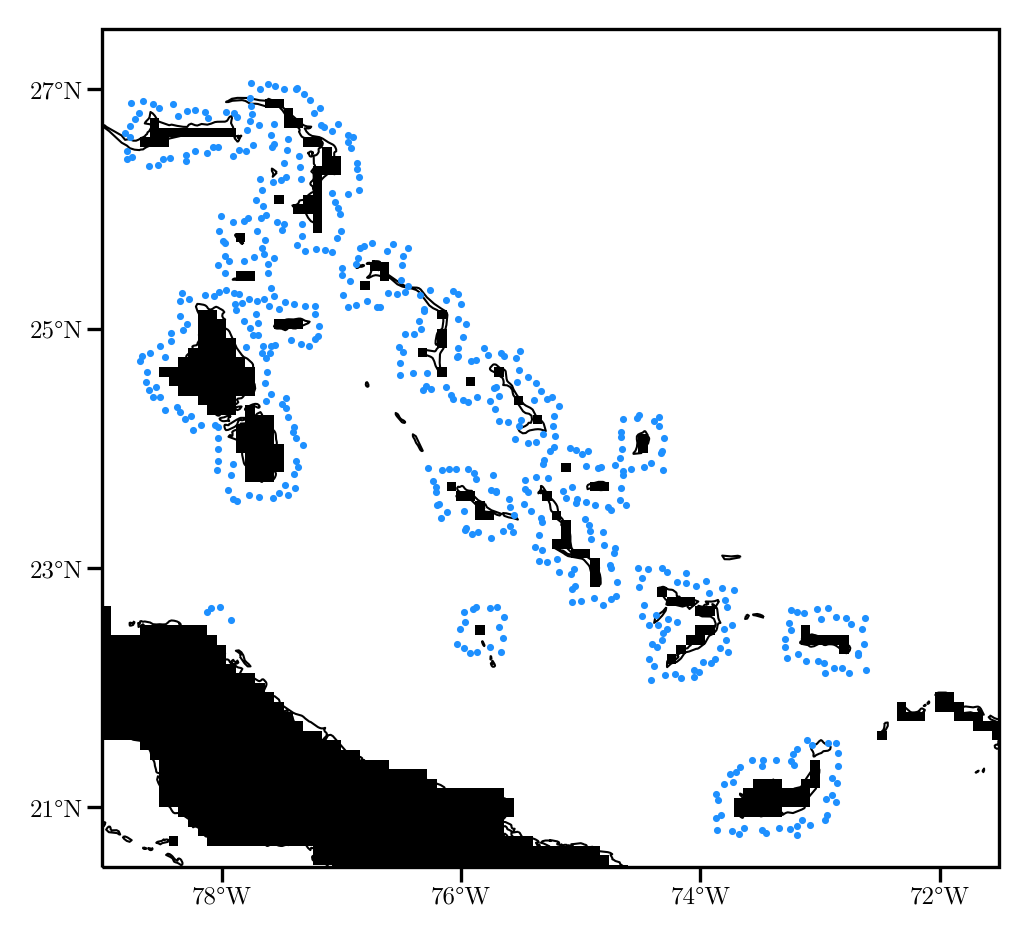

In [34]:
fig = plt.figure(dpi=300, figsize=(fsh[0],fsh[0]*0.9))
ax = fig.add_subplot(1,1,1,aspect='equal', projection=ccrs.PlateCarree())

c_id = 1
r = np.where(coast_cid == c_id)[0]

ax.pcolormesh(qlon, qlat, land, transform=ccrs.PlateCarree(), cmap='binary')
ax.scatter(coast_x[r], coast_y[r], color='dodgerblue', s=0.5, transform=ccrs.PlateCarree(), zorder=3)

geo_map(ax, land=False)

ax.set_xlim([-79, -71.5])
ax.set_ylim([20.5, 27.5])
ax.set_xticks([-78, -76, -74, -72], crs=ccrs.PlateCarree())
ax.set_yticks([21, 23, 25, 27], crs=ccrs.PlateCarree())

fig.savefig(f'figures/distribution_uniform_bahamas.png', format='png', dpi=600)

# Export csv per country

In [38]:
# coast
df_c = pd.DataFrame({
    'longitude': coast_x,
    'latitude': coast_y,
    'weight [ton]': coast_w,
    'country id': coast_cid,
    })

output_folder = '../data/process/'
df_c.to_csv(join(output_folder, f"coasts_uniform_weighted.csv"), index=False)

In [39]:
for i, c in enumerate(caribbean_countries):
    r = np.where(coast_cid == i)

    # coast
    df_c = pd.DataFrame({
        'longitude': coast_x[r],
        'latitude': coast_y[r],
        'weight [ton]': coast_w[r],
        'country id': coast_cid[r],
        })
    
    output_folder = '../data/process/uniform_per_country_weighted'
    df_c.to_csv(join(output_folder, f"c{i:02d}_{c.replace(',', '').lower().replace(' ', '-')}.csv"), index=False)